In [32]:
import os
import re
import nltk
import random
import json
import enchant
import pickle
import numpy as np
from textblob import TextBlob
from collections import Counter
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import wordnet as w,stopwords 
from sklearn.feature_extraction.text import CountVectorizer

In [33]:
#initialising dictionary, tokenizer, stemmer and all stopwords
dictionary = enchant.Dict("en_US")
tokenizer=RegexpTokenizer('[a-zA-Z]+')
ps=PorterStemmer()
all_stopwords=stopwords.words('english')

In [34]:
def preprocess(data):       # input - sentences   output -preprocessed sentences
    dataset=[]
    for sentence in data:
        #print 'sentence : '+sentence
        temp=tokenizer.tokenize(sentence)
        #print 'tokenizer : '+ str(temp)  
        remove_stopword=[word for word in temp if word not in all_stopwords]    # removing stopwords
        #print 'stopwords : '+str(remove_stopword)
        only_english=[word for word in remove_stopword if dictionary.check(word)== True]  # remove non-english words
        #print 'removed all non-english words: '+str(only_english)
        #print ' '
        if(len(only_english)>1):                  #appends only if length of list >1
            dataset.append(' '.join(only_english))
    return dataset    

In [35]:
#loading and cleaning dataset
def preprocessing(company_name):
    dataset=[]
    sentences=[]
    with open('TestReview/'+company_name+'/review.txt') as f:
        reviews=json.load(f)
    reviews=np.asarray(reviews)
    reviews=np.concatenate(reviews)        #converting it to single list from list of lists
    for review in reviews:
        review=review.lower()             #converting reviews into lowercase
        review=review.replace('. ',' ; ')                            
        sentences.extend(re.split(' and | but |; | ; |.and ',review))       #splitting criteria
    dataset=preprocess(sentences)
    with open('Dataset/'+company_name+'.txt','w') as f:
        json.dump(dataset,f)
    return dataset

In [36]:
#only for printing  
dataset=preprocessing('Samsung')

In [37]:
#only for testing    
print dataset[:10]

[u'long working hours', u'get little time family', u'process oriented', u'end result oriented', u'want results cost', u'mostly hard', u'buyer boring', u'even need spend money like every job', u'boring beginning', u'become habit']


In [38]:
#loading vocab for navebayes unigram
with open('../NaiveBayes/vocab') as f:
    vocab_nb_uni=json.load(f)
def extract_features_unigram_nb(document):       #features are bag of words. document is a list of words of a sentence 
    features = {}
    document= [ps.stem(word) for word in document]
    for word in vocab_nb_uni:
        features['contains(%s)' % word] = (word in document)
    return features

In [39]:
#fetching aspects
aspects={}
for root, dirs, files in os.walk('../Aspects/'):
        for name in files:
            with open('../Aspects/'+name) as f:
                aspects[name]=json.load(f)          #loading pool of words for each aspects
                        
def analyse_aspect(tokens):            # analyses to which aspect a set of tokens of a sentence belong to
    count=0
    #print 'Tokens : '+ str(tokens)
    aspects_in_sentence=[]
    for token in tokens:
        temp_token=ps.stem(token)
        for aspect_name in files:                               #each aspect
            for aspect in aspects[aspect_name]:                 #each word in an aspect
                temp_aspect=ps.stem(aspect)
                if(temp_token == temp_aspect):
                    aspects_in_sentence.append(aspect_name)
                    count=1
                    break
    if(count==0):
        aspects_in_sentence.append('Aspect7')
    #print 'List Of Aspects : '+ str(aspects_in_sentence)
    return   aspects_in_sentence          #aspect names in which it belongs

In [10]:
#only for testing
testing=analyse_aspect(['great','learning','with','good','salary'])

Tokens : ['great', 'learning', 'with', 'good', 'salary']
List Of Aspects : ['Aspect1', 'Aspect2']


In [40]:
#naiveBayes
def naiveBayes_unigram(dataset,aspect_analysis):        #first find the polarity and then its aspect
    #loading naivebayes classifier
    with open('../NaiveBayes/naive_bayes_unigram_model') as f:
        classifier=pickle.load(f)    
    aspect_polarity=Counter()
    aspect_count=Counter()
    for sentence in dataset:
        #print ' '
        #print 'sentence : '+sentence
        #print 'Polarity= '+classifier.classify(extract_features_unigram_nb(sentence.split()))
        polarity=0
        flag=0        
        dist = classifier.prob_classify(extract_features_unigram_nb(sentence.split()))
        for label in dist.samples():
            #print(" %s: %f" % (label, dist.prob(label)))
            if(polarity<dist.prob(label)):
                polarity=dist.prob(label)
                flag=label 
        if(flag == 'neg'):
            polarity=-polarity
        #print 'final polarity='+ str(polarity)
        #print ' '
        if('neutral'!= flag):
            if aspect_analysis == 'lexical':
                aspects_in_sentence=analyse_aspect(sentence.split())    # returns list of aspects where polarity should be added
            elif aspect_analysis == 'naivebayes':
                aspects_in_sentence=analyse_aspect_naivebayes(sentence.split())
            for asp in aspects_in_sentence:
                aspect_polarity[asp]=aspect_polarity[asp]+polarity
                aspect_count[asp]=aspect_count[asp]+1
            #print 'aspect_polarity ='+str(aspect_polarity)
            #print ' '
            #print 'aspect_count ='+str(aspect_count)
        #print '---------------------------'
    return aspect_polarity,aspect_count

In [20]:
#for testing
aspect_polarity,aspect_count=naiveBayes_unigram(dataset[50:100],'lexical')

 
sentence : challenges problems new technology
Polarity= pos
 neg: 0.090799
 pos: 0.909201
final polarity=0.909201095269
 
aspect_polarity =Counter({'Aspect1': 1.8184021905383028})
 
aspect_count =Counter({'Aspect1': 2})
---------------------------
 
sentence : developed bandwidth optimization degree video streaming
Polarity= pos
 neg: 0.116462
 pos: 0.883538
final polarity=0.883538147365
 
aspect_polarity =Counter({'Aspect1': 1.8184021905383028, 'Aspect7': 0.8835381473645518})
 
aspect_count =Counter({'Aspect1': 2, 'Aspect7': 1})
---------------------------
 
sentence : implemented video repair algorithms server streaming
Polarity= pos
 neg: 0.203832
 pos: 0.796168
final polarity=0.796168321877
 
aspect_polarity =Counter({'Aspect1': 1.8184021905383028, 'Aspect7': 1.679706469241291})
 
aspect_count =Counter({'Aspect7': 2, 'Aspect1': 2})
---------------------------
 
sentence : seniors helped
Polarity= pos
 neg: 0.139267
 pos: 0.860733
final polarity=0.860733232029
 
aspect_polarity =C

In [23]:
def plot(y_axis,x_axis,company_name):                     # plots a bar graph
    fig, ax = plt.subplots()    
    width = 0.75  # the width of the bars 
    ind = np.arange(len(y_axis))                          
    for i, v in enumerate(y_axis):                       
        ax.text(v , i, str(v), color='blue', fontweight='bold')
    ax.barh(ind, y_axis, width, color="blue")     
    ax.set_yticks(ind+width/2)                            # aligning at center 
    ax.set_yticklabels(x_axis, minor=False)
    plt.title(company_name)
    plt.xlabel('Polarity')
    plt.ylabel('Aspects')      
    plt.show()

In [24]:
# displaying the Result
def result(aspect_polarity,aspect_count,company_name):    #input - polarity for each aspec and its count
    total_polarity=0
    aspect_x_axis=[]
    aspect_y_axis=[]
    for aspect_name in files:
        if(aspect_count[aspect_name]!=0):                 
            polarity=aspect_polarity[aspect_name]/aspect_count[aspect_name]   
            total_polarity=total_polarity+polarity
        else:
            polarity=0
        aspect_x_axis.append(round(polarity,4))
        aspect_y_axis.append(str(aspects[aspect_name][0]))
    if(aspect_count['Aspect7']!=0):
        polarity=aspect_polarity['Aspect7']/aspect_count['Aspect7']
        aspect_x_axis.append(round(polarity,4))
        aspect_y_axis.append(str('General'))
    plot(aspect_x_axis,aspect_y_axis,company_name)
    total_polarity=total_polarity+polarity    
    total_polarity=total_polarity/7
    print 'Overall Polarity  '+str(total_polarity)        

# Result

Aspect Classifier = Lexical


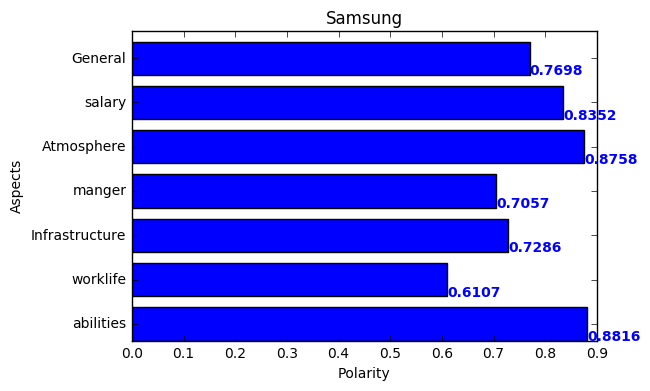

Overall Polarity  0.772476292457


In [28]:
aspect_polarity2,aspect_count2=naiveBayes_unigram(dataset[2000:3000],'lexical')
#with open('aspect_polarity1','w') as f:
#    json.dump(aspect_polarity1,f) 
#with open('aspect_count1','w') as f:
#    json.dump(aspect_count1,f)
result(aspect_polarity2 , aspect_count2,'Samsung')